In [1]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset


class CoronarySmallDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        

        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        # image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        # mask = cv2.cvtColor(mask, cv2.COLOR_RGBA2RGB)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        if self.transform:
            image = self.transform(image)
            # mask = self.transform(mask)
            mask = torch.tensor(mask, dtype=torch.long)
        
        return image, mask

In [14]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode


transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(1.0, 1.0), interpolation=InterpolationMode.NEAREST),
    transforms.RandomRotation(degree=(-30, 30), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

train_image_dir = '..\images\images_train\input'
train_mask_dir = '..\images\images_train\output'
val_image_dir = '..\images\images_val\input'
val_mask_dir = '..\images\images_val\output'
test_image_dir = '..\images\images_test\input'
test_mask_dir = '..\images\images_test\output'

train_dataset = CoronarySmallDataset(train_image_dir, train_mask_dir, transform=transform)
val_dataset = CoronarySmallDataset(val_image_dir, val_mask_dir, transform=transform)
test_dataset = CoronarySmallDataset(test_image_dir, test_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)


TypeError: RandomRotation.__init__() got an unexpected keyword argument 'degree'

In [15]:
from large_RGB_model import UNet


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

In [16]:
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.2e-4)
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, criterion, optimizer, model_name, num_epochs=50, early_stopping=3):
    best_loss = float('inf')
    epoch_with_improvement = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_loss:
            best_loss = val_loss
            epoch_with_improvement = epoch
            torch.save(model.state_dict(), f"{model_name}.pth")
        
        if epoch - epoch_with_improvement > early_stopping:
            print('Early stopping')
            break


In [17]:
train_model(model, train_loader, val_loader, criterion, optimizer,
            "large_RGB_model_dropout", num_epochs=60, early_stopping=3)

  0%|          | 0/93 [00:00<?, ?it/s]


TypeError: Unexpected type <class 'numpy.ndarray'>

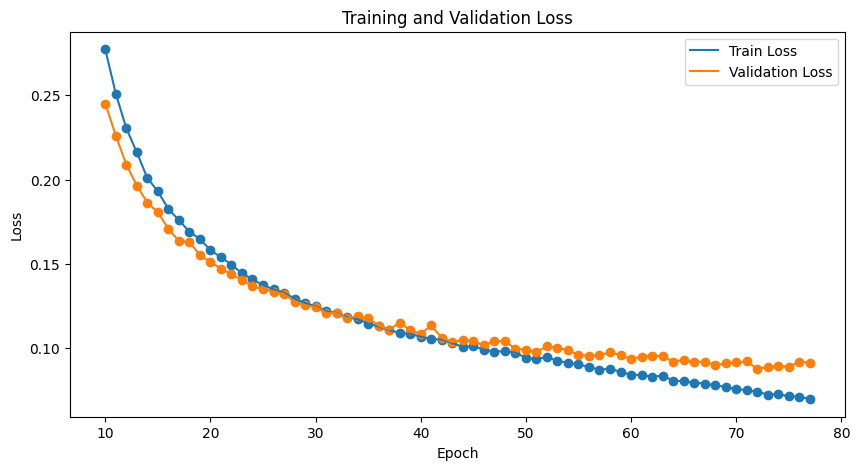

In [36]:
starting_epoch = 10
y = list(range(starting_epoch, len(train_losses)))
plt.figure(figsize=(10, 5))
plt.plot(y, train_losses[starting_epoch:], label='Train Loss')
plt.scatter(y, train_losses[starting_epoch:])
plt.plot(y, val_losses[starting_epoch:], label='Validation Loss')
plt.scatter(y, val_losses[starting_epoch:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

100%|██████████| 93/93 [04:33<00:00,  2.94s/it]


Epoch 1/65, Train Loss: 2.3796, Val Loss: 2.0397


100%|██████████| 93/93 [05:17<00:00,  3.42s/it]


Epoch 2/65, Train Loss: 1.8246, Val Loss: 1.6172


100%|██████████| 93/93 [05:27<00:00,  3.53s/it]


Epoch 3/65, Train Loss: 1.4680, Val Loss: 1.3171


100%|██████████| 93/93 [05:22<00:00,  3.47s/it]


Epoch 4/65, Train Loss: 1.1666, Val Loss: 1.0045


100%|██████████| 93/93 [05:35<00:00,  3.61s/it]


Epoch 5/65, Train Loss: 0.9214, Val Loss: 0.8232


100%|██████████| 93/93 [05:33<00:00,  3.58s/it]


Epoch 6/65, Train Loss: 0.7275, Val Loss: 0.6576


100%|██████████| 93/93 [05:42<00:00,  3.68s/it]


Epoch 7/65, Train Loss: 0.5816, Val Loss: 0.5481


100%|██████████| 93/93 [05:38<00:00,  3.64s/it]


Epoch 8/65, Train Loss: 0.4718, Val Loss: 0.4246


100%|██████████| 93/93 [05:44<00:00,  3.71s/it]


Epoch 9/65, Train Loss: 0.3910, Val Loss: 0.3664


100%|██████████| 93/93 [05:43<00:00,  3.70s/it]


Epoch 10/65, Train Loss: 0.3307, Val Loss: 0.3146


100%|██████████| 93/93 [05:42<00:00,  3.69s/it]


Epoch 11/65, Train Loss: 0.2853, Val Loss: 0.2791


100%|██████████| 93/93 [05:43<00:00,  3.69s/it]


Epoch 12/65, Train Loss: 0.2500, Val Loss: 0.2442


100%|██████████| 93/93 [05:43<00:00,  3.70s/it]


Epoch 13/65, Train Loss: 0.2235, Val Loss: 0.2187


100%|██████████| 93/93 [05:43<00:00,  3.69s/it]


Epoch 14/65, Train Loss: 0.2029, Val Loss: 0.2003


100%|██████████| 93/93 [06:02<00:00,  3.90s/it]


Epoch 15/65, Train Loss: 0.1852, Val Loss: 0.1910


100%|██████████| 93/93 [05:45<00:00,  3.72s/it]


Epoch 16/65, Train Loss: 0.1692, Val Loss: 0.1831


100%|██████████| 93/93 [05:44<00:00,  3.71s/it]


Epoch 17/65, Train Loss: 0.1547, Val Loss: 0.1648


100%|██████████| 93/93 [05:42<00:00,  3.68s/it]


Epoch 18/65, Train Loss: 0.1435, Val Loss: 0.1558


100%|██████████| 93/93 [05:38<00:00,  3.64s/it]


Epoch 19/65, Train Loss: 0.1362, Val Loss: 0.1456


100%|██████████| 93/93 [05:43<00:00,  3.69s/it]


Epoch 20/65, Train Loss: 0.1265, Val Loss: 0.1413


100%|██████████| 93/93 [05:49<00:00,  3.76s/it]


Epoch 21/65, Train Loss: 0.1204, Val Loss: 0.1388


100%|██████████| 93/93 [06:06<00:00,  3.94s/it]


Epoch 22/65, Train Loss: 0.1141, Val Loss: 0.1295


100%|██████████| 93/93 [06:13<00:00,  4.02s/it]


Epoch 23/65, Train Loss: 0.1081, Val Loss: 0.1303


100%|██████████| 93/93 [06:11<00:00,  3.99s/it]


Epoch 24/65, Train Loss: 0.1036, Val Loss: 0.1298


100%|██████████| 93/93 [06:07<00:00,  3.95s/it]


Epoch 25/65, Train Loss: 0.0982, Val Loss: 0.1218


100%|██████████| 93/93 [06:07<00:00,  3.95s/it]


Epoch 26/65, Train Loss: 0.0940, Val Loss: 0.1187


100%|██████████| 93/93 [06:08<00:00,  3.96s/it]


Epoch 27/65, Train Loss: 0.0899, Val Loss: 0.1179


100%|██████████| 93/93 [06:06<00:00,  3.94s/it]


Epoch 28/65, Train Loss: 0.0868, Val Loss: 0.1173


100%|██████████| 93/93 [06:09<00:00,  3.97s/it]


Epoch 29/65, Train Loss: 0.0835, Val Loss: 0.1148


100%|██████████| 93/93 [06:08<00:00,  3.96s/it]


Epoch 30/65, Train Loss: 0.0799, Val Loss: 0.1220


100%|██████████| 93/93 [06:06<00:00,  3.94s/it]


Epoch 31/65, Train Loss: 0.0758, Val Loss: 0.1129


100%|██████████| 93/93 [06:07<00:00,  3.95s/it]


Epoch 32/65, Train Loss: 0.0729, Val Loss: 0.1132


100%|██████████| 93/93 [05:55<00:00,  3.83s/it]


Epoch 33/65, Train Loss: 0.0704, Val Loss: 0.1073


100%|██████████| 93/93 [05:46<00:00,  3.73s/it]


Epoch 34/65, Train Loss: 0.0664, Val Loss: 0.1063


100%|██████████| 93/93 [05:45<00:00,  3.71s/it]


Epoch 35/65, Train Loss: 0.0635, Val Loss: 0.1056


100%|██████████| 93/93 [05:53<00:00,  3.80s/it]


Epoch 36/65, Train Loss: 0.0607, Val Loss: 0.1058


100%|██████████| 93/93 [05:49<00:00,  3.76s/it]


Epoch 37/65, Train Loss: 0.0586, Val Loss: 0.1055


100%|██████████| 93/93 [05:56<00:00,  3.83s/it]


Epoch 38/65, Train Loss: 0.0560, Val Loss: 0.1099


100%|██████████| 93/93 [05:51<00:00,  3.78s/it]


Epoch 39/65, Train Loss: 0.0526, Val Loss: 0.1040


100%|██████████| 93/93 [06:02<00:00,  3.90s/it]


Epoch 40/65, Train Loss: 0.0506, Val Loss: 0.1108


100%|██████████| 93/93 [06:03<00:00,  3.91s/it]


Epoch 41/65, Train Loss: 0.0496, Val Loss: 0.1052


100%|██████████| 93/93 [05:48<00:00,  3.75s/it]


Epoch 42/65, Train Loss: 0.0469, Val Loss: 0.1061


100%|██████████| 93/93 [05:54<00:00,  3.81s/it]


Epoch 43/65, Train Loss: 0.0447, Val Loss: 0.1079


100%|██████████| 93/93 [05:52<00:00,  3.79s/it]


Epoch 44/65, Train Loss: 0.0429, Val Loss: 0.1047
Early stopping


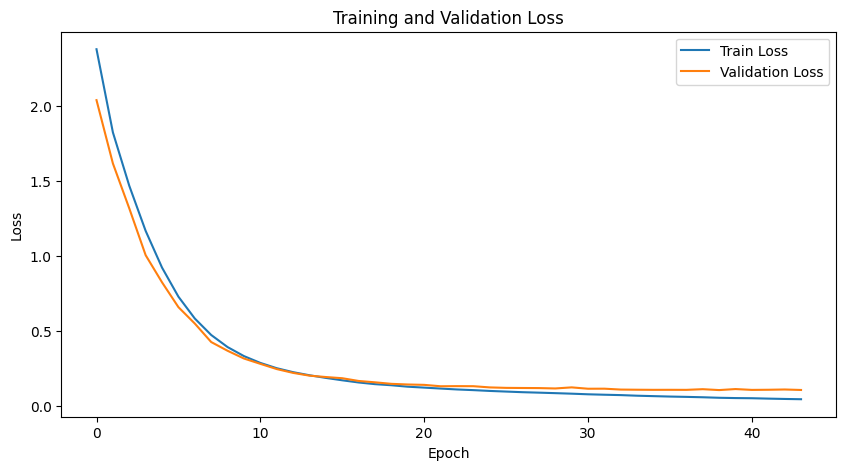

In [5]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=65, early_stopping=4)

In [8]:
import os
import numpy as np
import cv2
import torch
from torchvision import transforms
from converter_RGB import convert_int_to_RGB


model.load_state_dict(torch.load('large_RGB_model_dropout.pth'))
model.eval()

def show_image(type, image_name):
    dir = f"images_test\{type}"
    print(dir)
    if type == 'output':
        img = cv2.imread(os.path.join(dir, image_name), cv2.IMREAD_UNCHANGED)
        # img = img[:, :, 2]
        print(np.unique(img))  
        # print(img)
        img = convert_int_to_RGB(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    else:
        img = cv2.imread(os.path.join(dir, image_name), cv2.IMREAD_UNCHANGED)
        img = img * 7
    # img = cv2.resize(img, (256, 256))
    # np.set_printoptions(threshold=np.inf)
    cv2.imshow(type, img)

def predict(image_name):
    dir = 'images_test\input'
    img = cv2.imread(os.path.join(dir, image_name), cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (256, 256))
    img = transforms.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model.predict(img)
        pred = pred.squeeze().cpu().numpy()
    print(np.unique(pred))

    pred_image = convert_int_to_RGB(pred)
    pred_image = cv2.resize(pred_image, (512, 512))
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    cv2.imshow('pred', pred_image)
    cv2.waitKey(0)
   

In [16]:
# image_name = "131aedfhs6pnf1fvtvp49mhdb2fucqzo22_29.png"
image_name = "131aedfhs6pnf1fvtvp49mld7mqexnz322_36.png"
# image_name = "131aedfhs6pnf1fvtvp49mia892s56cf22_28.png"
# image_name = "131aedfhs6pnf1fvtvp49juwu7plj9dv22_40.png"
# image_name = "13c2ur549vohc0jat2dvu3xs7q1_18.png"

# treningowe
# image_name = "13c2ur549vohc0jat2e6y42xk11_31.png"
# image_name = "131aedfhs6pnf1fvtvp49jstof8iams322_36.png"
# image_name = "131aedfhs6pnf1fvtvp49mff2plx3rdw22_24.png"
show_image("input", image_name)
show_image("output", image_name)
predict(image_name)

images_test\input
images_test\output
[ 0  1  2  3  4 22]
[ 0  1  2  3  4  6 11 17 22]


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    correct_clear = 0
    total = 0
    total_clear = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model.predict(images)
            
            correct += (preds == masks).sum().item()
            correct_clear += (preds[masks != 0] == masks[masks != 0]).sum().item()
            total += masks.numel()
            total_clear += masks[masks != 0].numel()

    accuracy = correct / total
    accuracy_clear = correct_clear / total_clear
    return accuracy, accuracy_clear

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('large_RGB_model_dropout.pth'))

train_accuracy = compute_accuracy(model, train_loader, device)
val_accuracy = compute_accuracy(model, val_loader, device)
test_accuracy = compute_accuracy(model, test_loader, device)

print(f'Train Accuracy: {train_accuracy[0] * 100 :.2f}%')
print(f'Train Accuracy Clear: {train_accuracy[1] * 100 :.2f}%')
print()
print(f'Validation Accuracy: {val_accuracy[0] * 100 :.2f}%')
print(f'Validation Accuracy Clear: {val_accuracy[1] * 100 :.2f}%')
print()
print(f'Test Accuracy: {test_accuracy[0] * 100 :.2f}%')
print(f'Test Accuracy Clear: {test_accuracy[1] * 100 :.2f}%')

Train Accuracy: 98.15%
Train Accuracy Clear: 68.59%

Validation Accuracy: 97.39%
Validation Accuracy Clear: 56.62%

Test Accuracy: 97.59%
Test Accuracy Clear: 59.81%


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('large_RGB_model.pth'))

train_accuracy = compute_accuracy(model, train_loader, device)
val_accuracy = compute_accuracy(model, val_loader, device)
test_accuracy = compute_accuracy(model, test_loader, device)

print(f'Train Accuracy: {train_accuracy[0] * 100 :.2f}%')
print(f'Train Accuracy Clear: {train_accuracy[1] * 100 :.2f}%')
print()
print(f'Validation Accuracy: {val_accuracy[0] * 100 :.2f}%')
print(f'Validation Accuracy Clear: {val_accuracy[1] * 100 :.2f}%')
print()
print(f'Test Accuracy: {test_accuracy[0] * 100 :.2f}%')
print(f'Test Accuracy Clear: {test_accuracy[1] * 100 :.2f}%')

Train Accuracy: 98.80%
Train Accuracy Clear: 79.97%

Validation Accuracy: 97.25%
Validation Accuracy Clear: 54.30%

Test Accuracy: 97.53%
Test Accuracy Clear: 58.80%


In [ ]:
# Do poprawy, teraz nie ma sensu
# Musiałoby dla każdej klasu osobno liczyć
def compute_precision_recall_f1(model, data_loader, device, num_classes=28):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model.predict(images)
            
            all_preds.append(preds.view(-1).cpu().numpy())
            all_targets.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return precision, recall, f1